In [111]:
import glob
import os
import re
import sys
from collections import defaultdict
from functools import reduce, partial
from multiprocessing import Pool

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm

from pymutspec.annotation.spectra import get_cossim, complete_sbs192_columns
from pymutspec.annotation import CodonAnnotation, rev_comp
from pymutspec.constants import possible_sbs192
from pymutspec.draw import plot_mutspec192
import pymutspec

from Bio import SeqIO
from Bio.Data import CodonTable
from scipy import spatial

import warnings
warnings.filterwarnings("ignore")

In [2]:
paths12 = glob.glob('../data/chordata2/output/*/*/tables/ms12syn.tsv')
paths192 = glob.glob('../data/chordata2/output/*/*/tables/ms192syn.tsv')
paths12_internal = glob.glob('../data/chordata2/output/*/*/tables/ms12syn_internal.tsv')
paths192_internal = glob.glob('../data/chordata2/output/*/*/tables/ms192syn_internal.tsv')

paths_history = glob.glob('../data/chordata2/output/*/*/.nextflow/history')

gene_species = set([x.split('/')[5] for x in paths12])

## Execution time

In [3]:
h_pattern = re.compile("(\d{0,2})h")
m_pattern = re.compile("(\d{0,2})m")
s_pattern = re.compile("(\d{0,2})s")

def time_fmt(s):
    hours = mins = secs = 0
    h = h_pattern.search(s)
    if h:
        hours = int(h.group()[:-1])
    m = m_pattern.search(s)
    if m:
        mins = int(m.group()[:-1])
    sec = s_pattern.search(s)
    if sec:
        secs = int(sec.group()[:-1])
    return hours * 60 + mins + secs / 60

In [4]:
time_fmt('2h 1m 21s')

121.35

In [18]:
data = []
nerr = 0
for p in paths_history:
    p_elements = p.split('/')
    if p_elements[-3] in gene_species:
        gene = p_elements[-4]
        gs = p_elements[-3]
        hist = pd.read_csv(p, sep='\t', header=None).iloc[0]
        ok = hist[3]
        if ok != 'OK':
            nerr += 1
        time_raw = hist[1]
        minuts = time_fmt(time_raw)
        nleaves = 0
        with open('/'.join(p_elements[:-2]) + '/logs/branches.txt') as fin:
            for line in fin:
                nleaves += 1
        data.append([nleaves, minuts, gene, gs])

df = pd.DataFrame(data, columns=['nleaves', 'minuts', 'gene', 'gs'])

In [19]:
df.sort_values('minuts', ascending=False)

,nleaves,minuts,gene,gs
3152,500,94.066667,CO1,CO1__Pyura_chilensis
6407,501,49.883333,Cytb,Cytb__Homo_sapiens
306,492,41.900000,ND1,ND1__Homo_sapiens
759,469,41.100000,ND2,ND2__Heteronotia_binoei
7826,495,40.350000,ND4,ND4__Homo_sapiens
...,...,...,...,...
2380,18,0.016667,ND6,ND6__Syncerus_caffer
2278,15,0.016667,ND6,ND6__Setophaga_castanea
2384,11,0.016667,ND6,ND6__Aepyornis_maximus
6947,12,0.016667,ND3,ND3__Schetba_rufa


In [9]:
df.groupby('gene')[['nleaves', 'minuts']].describe()

nleaves                                                         minuts  \
       count       mean        std   min    25%   50%    75%    max   count   
gene                                                                          
A6     487.0  28.597536  31.753912  11.0  15.00  19.0  31.00  502.0   487.0   
A8     180.0  22.316667  36.475365  11.0  13.00  16.0  22.00  485.0   180.0   
CO1   1011.0  24.358061  33.986491  11.0  12.00  16.0  24.00  501.0  1011.0   
CO2    235.0  24.434043  35.546029  11.0  14.00  17.0  23.50  490.0   235.0   
CO3    245.0  27.518367  39.673729  11.0  14.00  17.0  26.00  500.0   245.0   
Cytb  3215.0  34.829238  40.356375  11.0  14.00  21.0  38.00  501.0  3215.0   
ND1    403.0  31.059553  38.871090  11.0  14.00  20.0  32.00  492.0   403.0   
ND2   1821.0  33.030752  38.998706  11.0  14.00  21.0  35.00  469.0  1821.0   
ND3    233.0  24.184549  32.782793  11.0  13.00  16.0  25.00  469.0   233.0   
ND4    716.0  31.515363  35.265047  11.0  14.75  21.0  33.25  495.0   716.0   
ND4L   129.0  24.333333  40.834141  11.0  13.00  16.0  23.00  458.0   129.0   
ND5    312.0  35.945513  46.984231  11.0  15.00  23.0  35.25  484.0   312.0   
ND6    245.0  27.061224  37.137984  11.0  14.00  18.0  26.00  487.0   245.0   

                                                                             
          mean       std       min       25%       50%       75%        max  
gene                                                                         
A6    1.551985  1.490055  0.016667  1.133333  1.366667  1.691667  22.366667  
A8    0.732222  1.485333  0.016667  0.100000  0.150000  1.133333  18.650000  
CO1   2.940109  3.358016  1.400000  2.266667  2.583333  2.966667  94.066667  
CO2   1.663404  1.753221  0.016667  1.200000  1.416667  1.716667  24.483333  
CO3   1.666054  2.062087  0.016667  1.133333  1.333333  1.700000  28.033333  
Cytb  2.529762  2.290499  1.000000  1.733333  1.966667  2.516667  49.883333  
ND1   2.395037  2.615981  0.050000  1.450000  1.766667  2.675000  41.900000  
ND2   2.981997  2.282577  1.083333  2.283333  2.650000  3.050000  41.100000  
ND3   1.230258  1.288952  0.016667  1.033333  1.200000  1.450000  17.516667  
ND4   2.026839  2.312624  0.016667  1.400000  1.600000  2.016667  40.350000  
ND4L  1.103618  2.241430  0.016667  0.100000  1.133333  1.283333  25.183333  
ND5   2.582158  3.455347  0.016667  1.579167  1.850000  2.383333  38.516667  
ND6   1.288639  1.463739  0.016667  1.016667  1.216667  1.466667  18.750000

In [10]:
df[df.nleaves.between(80, 120)].groupby('gene').minuts.describe()

,count,mean,std,min,25%,50%,75%,max
gene,,,,,,,,
A6,13.0,3.938462,1.029257,2.816667,3.250000,3.683333,3.916667,5.983333
A8,1.0,3.716667,NaN,3.716667,3.716667,3.716667,3.716667,3.716667
CO1,14.0,6.153571,1.469900,4.083333,5.162500,5.875000,6.937500,8.600000
CO2,2.0,3.866667,0.235702,3.700000,3.783333,3.866667,3.950000,4.033333
CO3,8.0,3.870833,0.536135,3.000000,3.508333,3.983333,4.245833,4.550000
Cytb,150.0,4.639778,0.924764,3.216667,3.987500,4.450000,5.166667,7.016667
ND1,16.0,4.535417,0.972147,3.300000,3.745833,4.275000,4.933333,6.766667
ND2,80.0,5.270833,1.384746,3.616667,4.408333,4.925000,5.812500,12.733333
ND3,2.0,3.525000,0.671751,3.050000,3.287500,3.525000,3.762500,4.000000


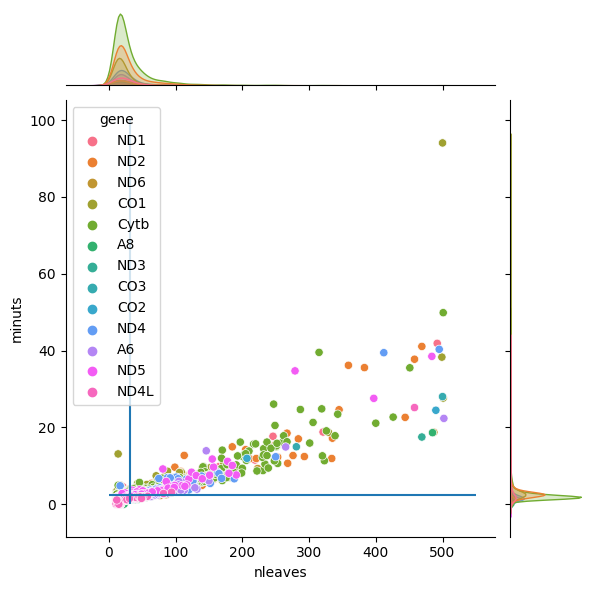

In [11]:
ax = sns.jointplot(df, x='nleaves', y='minuts', hue='gene')
plt.vlines([df.nleaves.mean()], 0, 100);
plt.hlines([df.minuts.mean()], 0, 550);


## Aggregate

In [4]:
paths12 = glob.glob('../data/chordata2/output/*/*/tables/ms12syn.tsv')
paths192 = glob.glob('../data/chordata2/output/*/*/tables/ms192syn.tsv')
paths12_internal = glob.glob('../data/chordata2/output/*/*/tables/ms12syn_internal.tsv')
paths192_internal = glob.glob('../data/chordata2/output/*/*/tables/ms192syn_internal.tsv')

In [4]:
total_data = []
for lbl, paths in zip(['12', '192', '12_internal', '192_internal'],
                      [paths12, paths192, paths12_internal, paths192_internal]):
    data = []
    for p in tqdm.tqdm(paths, 'Species-Gene'):
        gene, species = p.split('/')[5].split('__')
        spectrum = pd.read_csv(p, sep='\t')
        spectrum = spectrum.assign(Species=species, Gene=gene)
        data.append(spectrum)
    df = pd.concat(data)
    total_data.append(df.copy())
    df.to_csv(f'../data/chordata2/raw_spectum{lbl}.csv')

Species-Gene: 100%|██████████| 5925/5925 [00:11<00:00, 508.59it/s]


## Process

In [3]:
total_data = [
    pd.read_csv('../data/chordata2/raw_spectum12.csv', index_col=0),
    pd.read_csv('../data/chordata2/raw_spectum192.csv', index_col=0),
    pd.read_csv('../data/chordata2/raw_spectum12_internal.csv', index_col=0),
    pd.read_csv('../data/chordata2/raw_spectum192_internal.csv', index_col=0),
]

In [4]:
df_info = pd.read_csv('../data/chordata2/info.csv')
df_info['species'] = df_info['species'].str.replace(' ', '_')
df_info

,acc,gene,taxa,species
0,AB478558.1.8820.9502_BAH86124.1,A6,Chordata_7711;Leptocardii_2682552;Amphioxiform...,Branchiostoma_belcheri
1,AB478590.1.8806.9488_BAH86540.1,A6,Chordata_7711;Leptocardii_2682552;Amphioxiform...,Branchiostoma_floridae
2,Y09525.1.238.>921_CAA70712.1,A6,Chordata_7711;Leptocardii_2682552;Amphioxiform...,Branchiostoma_lanceolatum
3,KP722183.1.159.>838_AJV90905.1,A6,Chordata_7711;Hyperoartia_117569;Petromyzontif...,Lampetra_fluviatilis
4,FR669668.2.1432.>2101_CBW30998.1,A6,Chordata_7711;Hyperoartia_117569;Petromyzontif...,Lampetra_planeri
...,...,...,...,...
18932,KY676708.1.1.519_AVM18678.1,ND6,Chordata_7711;Amphibia_8292;Caudata_8293;Pleth...,Eurycea_braggi
18933,KY676695.1.1.519_AVM18665.1,ND6,Chordata_7711;Amphibia_8292;Caudata_8293;Pleth...,Eurycea_spelaea
18934,EU880310.1.14048.13530_ACJ43568.1,ND6,Chordata_7711;Amphibia_8292;Caudata_8293;Salam...,Cynops_ensicauda
18935,EU880313.1.14046.13528_ACJ43607.1,ND6,Chordata_7711;Amphibia_8292;Caudata_8293;Salam...,Cynops_pyrrhogaster


### Calculate class abundance

In [22]:
cab = total_data[0].merge(df_info, right_on=['species', 'gene'], left_on=['Species', 'Gene'])
cab['cls'] = cab.taxa.apply(lambda x: ' '.join(x.split(';')[1].split('_')[:-1]))
abund = cab.drop_duplicates(['species', 'gene']).groupby(['cls', 'gene']).Species.count()\
    .unstack().fillna(0).astype(int).sort_values('Cytb', ascending=False)

In [23]:
abund = abund.append(pd.Series({'Cytb': 33962,
         'CO1': 33506,
         'ND2': 23602,
         'ND4': 14985,
         'ND3': 12754,
         'ND1': 12684,
         'A6': 12543,
         'A8': 12033,
         'CO2': 10931,
         'ND5': 10789,
         'CO3': 10428,
         'ND4L': 10350,
         'ND6': 10300}, name='Total'))

abund.to_csv('../data/supplementary_files/Supplementary_Table_3.csv')

In [24]:
abund

,A6,A8,CO1,CO2,CO3,Cytb,ND1,ND2,ND3,ND4,ND4L,ND5,ND6
cls,,,,,,,,,,,,,
Mammalia,121,70,309,145,142,1123,153,210,97,174,81,155,118
Actinopteri,167,56,334,31,34,1026,76,235,25,68,21,57,40
Lepidosauria,51,21,110,7,8,435,61,425,5,337,5,12,8
Aves,122,23,79,40,44,314,44,718,79,60,14,57,61
Amphibia,14,5,135,8,13,242,63,181,22,52,5,20,12
class Testudines,0,0,3,0,0,40,1,1,1,16,0,2,2
class Crocodylia,1,1,3,1,1,10,1,1,1,1,1,1,1
Hyperoartia,2,1,1,0,0,9,0,1,1,0,0,0,0
Chondrichthyes,5,3,15,1,1,8,1,46,0,5,0,4,1


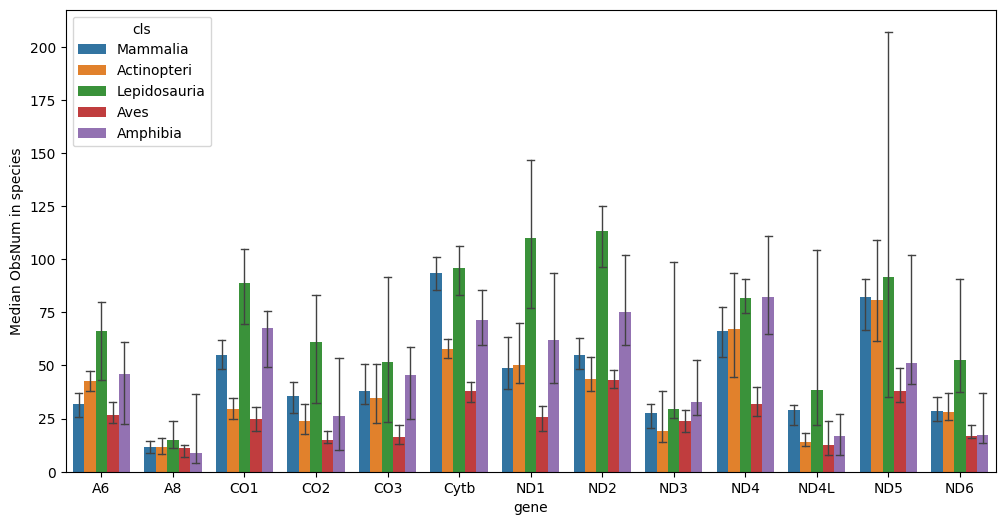

In [31]:
plt.figure(figsize=(12, 6))
sns.barplot(
    data=cab.groupby(['cls', 'gene', 'species']).ObsNum.sum().reset_index(), 
    x='gene', y='ObsNum', hue='cls', 
    hue_order=['Mammalia', 'Actinopteri', 'Lepidosauria', 'Aves', 'Amphibia'],
    capsize=0.1, estimator='median', errwidth=1,
).set_ylabel('Median ObsNum in species');

## Find errors

## Get final tables; find min number of mutations threshold 

In [5]:
total_data[0]

,Mut,ObsNum,ExpNum,MutSpec,Species,Gene
0,A>G,11.97280,30.91470,0.370075,Eleotris_fusca,ND1
1,C>T,4.98631,46.08120,0.103398,Eleotris_fusca,ND1
2,G>A,6.98846,21.08200,0.316758,Eleotris_fusca,ND1
3,T>C,8.98184,40.91500,0.209769,Eleotris_fusca,ND1
4,T>A,0.00000,16.91510,0.000000,Eleotris_fusca,ND1
...,...,...,...,...,...,...
7,T>C,2.99998,40.79990,0.026493,Branchiostoma_belcheri,ND4L
8,T>G,3.99994,10.90000,0.132223,Branchiostoma_belcheri,ND4L
9,G>T,0.00000,4.69996,0.000000,Branchiostoma_belcheri,ND4L
10,A>C,0.00000,12.90000,0.000000,Branchiostoma_belcheri,ND4L


<AxesSubplot:>

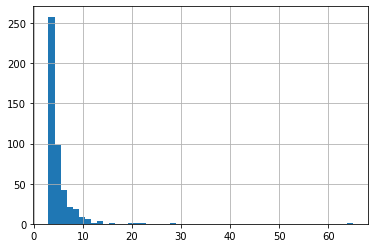

In [42]:
a = (total_data[0].ObsNum / total_data[0].ExpNum)
a[a > 3].hist(bins=50)

In [62]:
tr_space = np.linspace(0, 5, 100)
dlen = [total_data[0][(total_data[0].ExpNum.between(0, tr, 'right')) & (total_data[0].ObsNum.between(0, tr, 'right'))].shape[0] for tr in tr_space]

In [86]:
tr = 0.99
total_data[0][(total_data[0].ExpNum.between(0, tr, 'right')) & (total_data[0].ObsNum.between(0, tr, 'right'))] #& (~(total_data[0].ObsNum / total_data[0].ExpNum).fillna(0).between(0.8, 1.2))]

,Mut,ObsNum,ExpNum,MutSpec,Species,Gene
4,G>C,0.984329,0.532810,0.293537,Podarcis_lilfordi,ND2
6,G>T,0.981711,0.943558,0.099573,Pedioplanis_burchelli,ND2
6,G>T,0.808355,0.537496,0.197909,Didemnum_granulatum,CO1
4,G>A,0.899284,0.872553,0.368168,Crotaphytus_nebrius,Cytb
7,G>C,0.567060,0.320491,0.394275,Reithrodontomys_chrysopsis,Cytb
5,G>A,0.973297,0.571058,0.592833,Dipodomys_agilis,Cytb
6,G>T,0.800593,0.911391,0.123866,Misgurnus_anguillicaudatus,A8
4,G>T,0.984943,0.317911,0.396533,Phrynosoma_orbiculare,A8
2,G>A,0.966622,0.305126,0.656641,Dicrostonyx_torquatus,A8
1,C>A,0.317641,0.022745,0.694539,Pituophis_deppei,A8


In [91]:
total_data[0][(total_data[0].ExpNum.between(0.99, 1, 'right')) | (total_data[0].ObsNum.between(0.99, 1, 'right'))] 

,Mut,ObsNum,ExpNum,MutSpec,Species,Gene
3,C>G,1.00000,23.59860,0.012763,Anaxyrus_fowleri,ND1
1,A>T,1.00000,80.26720,0.011597,Anaxyrus_woodhousii,ND1
5,G>C,1.00000,6.67245,0.139505,Anaxyrus_woodhousii,ND1
2,A>T,1.00000,22.64750,0.021682,Corvus_corax,ND1
8,T>G,0.99997,21.06580,0.010808,Lasiopodomys_gregalis,ND1
...,...,...,...,...,...,...
1,C>A,1.00000,13.99980,0.103928,Macrhybopsis_aestivalis,ND4L
5,T>G,1.00000,8.98997,0.161843,Macrhybopsis_aestivalis,ND4L
2,C>A,0.99998,2.50000,0.144122,Branchiostoma_belcheri,ND4L
5,G>C,0.99995,4.69996,0.076659,Branchiostoma_belcheri,ND4L


In [93]:
get_cossim(
    total_data[0].pivot(['Gene', 'Species'], 'Mut', 'MutSpec'), 
    total_data[2].pivot(['Gene', 'Species'], 'Mut', 'MutSpec'),
).quantile([.25, .5, .75])

0.25    0.940835
0.50    0.981491
0.75    0.993853
dtype: float64

In [95]:
tr = 0.99
get_cossim(
    total_data[0][(total_data[0].ExpNum > tr) & (total_data[0].ObsNum > tr)].pivot(['Gene', 'Species'], 'Mut', 'MutSpec'), 
    total_data[2][(total_data[2].ExpNum > tr) & (total_data[2].ObsNum > tr)].pivot(['Gene', 'Species'], 'Mut', 'MutSpec'),
).quantile([.25, .5, .75])

0.25    0.937508
0.50    0.981007
0.75    0.993736
dtype: float64

In [96]:
tr = 0.99
get_cossim(
    total_data[0].pivot(['Gene', 'Species'], 'Mut', 'MutSpec'), 
    total_data[0][(total_data[0].ExpNum >= tr) & (total_data[0].ObsNum >= tr)].pivot(['Gene', 'Species'], 'Mut', 'MutSpec'),
).quantile([.05, .5])

0.05    0.988551
0.50    1.000000
dtype: float64

## Calculate Expected Mutspec with conservative sites for CytB

In [13]:
paths_msa = glob.glob('/home/kpotoh/nemu-pipeline/data/chordata2/output/Cytb/*/msa_nuc.fasta') 
len(paths_msa)

3218

In [14]:
coda = CodonAnnotation(gencode=2)

In [23]:
def my_process_parallel(seq: str):
    _, exp192 = coda.collect_exp_mut_freqs(seq, labels=['syn'])
    return exp192['syn']

In [24]:
msa = [str(r.seq) for r in list(SeqIO.parse(paths_msa[10], 'fasta')) if r.id != 'OUTGRP']
my_process_parallel(msa[0])


p = Pool(32)
_ = p.map(my_process_parallel, msa)

In [25]:
data = dict()
list_of_species = list()

i = 0
for path_fasta in tqdm.tqdm(paths_msa):
    i += 1
    p_elements = path_fasta.split('/')
    
    gene_species = p_elements[8]
    list_of_species.append(gene_species)

    msa = [str(r.seq) for r in list(SeqIO.parse(path_fasta, 'fasta')) if r.id != 'OUTGRP']
    raw_exp192 = p.map(my_process_parallel, msa)

    nseqs = len(msa)
    mean_exp192 = defaultdict(int)
    for sbs in possible_sbs192:
        for rex in raw_exp192:
            mean_exp192[sbs] += rex.get(sbs, 0) / nseqs
    
    data[gene_species] = mean_exp192

    # if i == 55:
    #      break

exp_final_df = pd.DataFrame(data).T

100%|██████████| 3218/3218 [00:50<00:00, 64.31it/s]


In [75]:
exp_final_df.to_csv('../data/chordata2/exp_num192_cytb.csv')

In [100]:
exp_final_df = pd.read_csv('../data/chordata2/exp_num192_cytb.csv', index_col=0)
exp_final_df.index = exp_final_df.index.str.slice(6)
exp_final_df.head(2)

,A[A>C]A,A[A>C]C,A[A>C]G,A[A>C]T,C[A>C]A,C[A>C]C,C[A>C]G,C[A>C]T,G[A>C]A,G[A>C]C,...,C[T>G]G,C[T>G]T,G[T>G]A,G[T>G]C,G[T>G]G,G[T>G]T,T[T>G]A,T[T>G]C,T[T>G]G,T[T>G]T
Aulacorhynchus_haematopygus,0.0,0.0,0.0,0.0,8.300000,4.300000,8.500000,8.6,2.800000,1.90000,...,3.000000,0.000000,0.0,0.900000,1.800000,1.000000,1.000000,1.500000,1.400000,1.800000
Tarsius_dentatus,0.0,0.0,0.0,0.0,11.571429,10.380952,10.142857,13.0,3.857143,3.47619,...,8.333333,4.142857,1.0,0.285714,1.190476,1.428571,3.047619,2.857143,2.142857,0.428571


### Species-specific compare: obs, exp and spectum

In [246]:
exp_freqs_new_full = exp_final_df[possible_sbs192]

obs_freqs_new = total_data[1].pivot(['Gene', 'Species'], 'Mut', 'ObsNum').loc['Cytb', possible_sbs192]
exp_freqs_new_excons = total_data[1].pivot(['Gene', 'Species'], 'Mut', 'ExpNum').loc['Cytb', possible_sbs192]

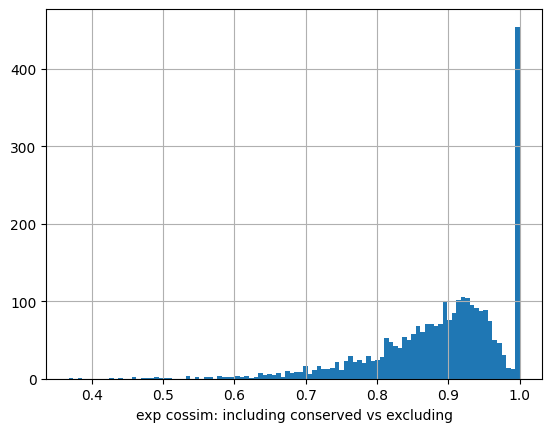

In [247]:
plt.xlabel('exp cossim: including conserved vs excluding')
get_cossim(exp_freqs_new_excons, exp_freqs_new_full).hist(bins=100);

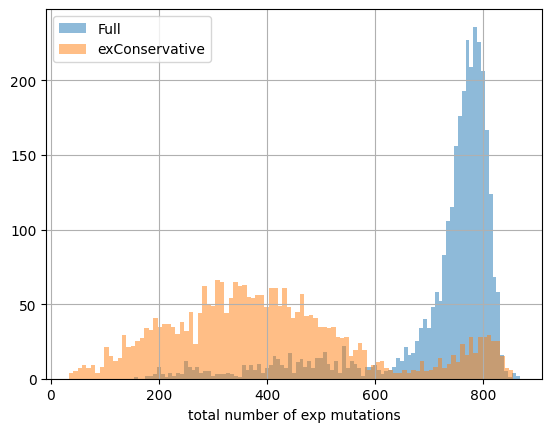

In [248]:
exp_freqs_new_full.sum(axis=1).hist(bins=100, alpha=0.5, label='Full')
exp_freqs_new_excons.sum(axis=1).hist(bins=100, alpha=0.5, label='exConservative')
plt.xlabel('total number of exp mutations')
plt.legend();

## Compare with old dataset 

In [241]:
spectra_old = pd.read_csv('../../192/data/MutSpecVertebratescytb.csv')
spectra_old['Mut'] = spectra_old['Mut'].apply(rev_comp)
spectra_old.head()

,Species,Mut,Expected,Observed,RawMutSpec,RawMutSpecSum,MutSpec,MutBase,Context,Class
0,Abbottina_obtusirostris,A[A>C]A,0.0,0.0,0.0,1.088889,0.0,T>G,TTT,Actinopterygii
1,Abbottina_obtusirostris,A[A>C]C,0.0,0.0,0.0,1.088889,0.0,T>G,GTT,Actinopterygii
2,Abbottina_obtusirostris,A[A>C]G,0.0,0.0,0.0,1.088889,0.0,T>G,CTT,Actinopterygii
3,Abbottina_obtusirostris,A[A>C]T,0.0,0.0,0.0,1.088889,0.0,T>G,ATT,Actinopterygii
4,Abbottina_obtusirostris,A[A>G]A,8.0,0.0,0.0,1.088889,0.0,T>C,TTT,Actinopterygii


In [249]:
obs_freqs_old = spectra_old.pivot('Species', 'Mut', 'Observed')[possible_sbs192]
exp_freqs_old = spectra_old.pivot('Species', 'Mut', 'Expected')[possible_sbs192]

In [250]:
thr = 0.9

obs_freqs_new_filtered = obs_freqs_new[obs_freqs_new > thr].fillna(0.)
obs_freqs_old_filtered = obs_freqs_old[obs_freqs_old > thr].fillna(0.)
exp_freqs_old_filtered = exp_freqs_old[exp_freqs_old > thr].fillna(0.)
exp_freqs_new_full_filtered = exp_freqs_new_full[exp_freqs_new_full > thr].fillna(0.)
exp_freqs_new_excons_filtered = exp_freqs_new_excons[exp_freqs_new_excons > thr].fillna(0.)

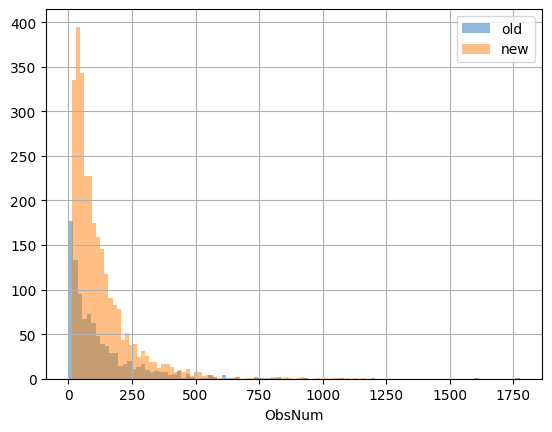

In [267]:
obs_freqs_old.sum(axis=1).hist(bins=100, label='old', alpha=0.5)
obs_freqs_new.sum(axis=1).hist(bins=100, label='new', alpha=0.5)
plt.xlabel('ObsNum')
plt.legend();

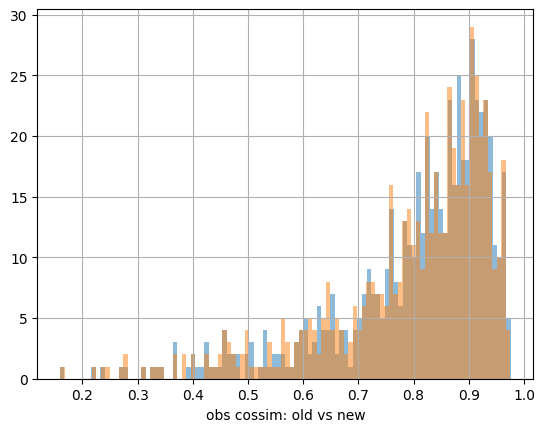

In [264]:
get_cossim(obs_freqs_new, obs_freqs_old).hist(bins=100, alpha=0.5)
get_cossim(obs_freqs_new_filtered, obs_freqs_old_filtered).hist(bins=100, alpha=0.5)
plt.xlabel('obs cossim: old vs new');

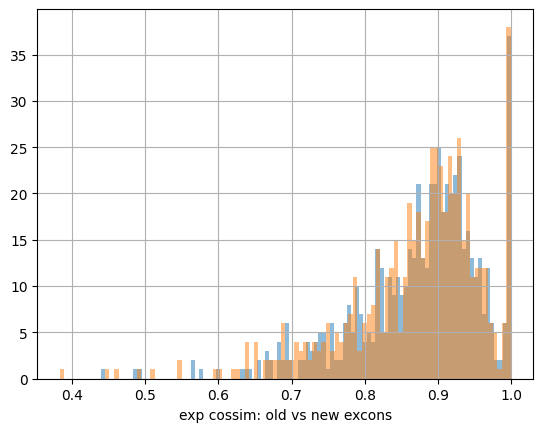

In [262]:
get_cossim(exp_freqs_new_excons, exp_freqs_old).hist(bins=100, alpha=0.5)
get_cossim(exp_freqs_new_excons_filtered, exp_freqs_old_filtered).hist(bins=100, alpha=0.5)
plt.xlabel('exp cossim: old vs new excons');

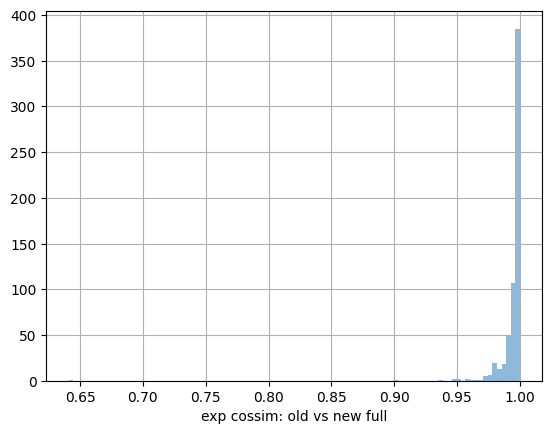

In [266]:
get_cossim(exp_freqs_new_full, exp_freqs_old).hist(bins=100, alpha=0.5)
plt.xlabel('exp cossim: old vs new full');

In [233]:
# spectrum_old = 
(obs_freqs_old / exp_freqs_old).fillna(0.)

Mut,A[A>C]A,A[A>C]C,A[A>C]G,A[A>C]T,C[A>C]A,C[A>C]C,C[A>C]G,C[A>C]T,G[A>C]A,G[A>C]C,...,C[T>G]G,C[T>G]T,G[T>G]A,G[T>G]C,G[T>G]G,G[T>G]T,T[T>G]A,T[T>G]C,T[T>G]G,T[T>G]T
Species,,,,,,,,,,,,,,,,,,,,,
Abbottina_obtusirostris,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Abbottina_rivularis,0.0,0.0,0.0,0.0,0.000000,0.1,0.000000,0.111111,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Abramis_brama,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Acanthogobius_hasta,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Acanthopagrus_latus,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Zacco_platypus,0.0,0.0,0.0,0.0,0.000000,0.0,0.333333,0.181818,0.0,0.2,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
Zeus_faber,0.0,0.0,0.0,0.0,0.083333,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
Zosterops_abyssinicus,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [269]:
obs_freqs_old

Mut,A[A>C]A,A[A>C]C,A[A>C]G,A[A>C]T,C[A>C]A,C[A>C]C,C[A>C]G,C[A>C]T,G[A>C]A,G[A>C]C,...,C[T>G]G,C[T>G]T,G[T>G]A,G[T>G]C,G[T>G]G,G[T>G]T,T[T>G]A,T[T>G]C,T[T>G]G,T[T>G]T
Species,,,,,,,,,,,,,,,,,,,,,
Abbottina_obtusirostris,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Abbottina_rivularis,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Abramis_brama,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Acanthogobius_hasta,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Acanthopagrus_latus,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Zacco_platypus,0.0,0.0,0.0,0.0,0.0,0.0,3.0,2.0,0.0,1.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
Zeus_faber,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
Zosterops_abyssinicus,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [270]:
exp_freqs_old

Mut,A[A>C]A,A[A>C]C,A[A>C]G,A[A>C]T,C[A>C]A,C[A>C]C,C[A>C]G,C[A>C]T,G[A>C]A,G[A>C]C,...,C[T>G]G,C[T>G]T,G[T>G]A,G[T>G]C,G[T>G]G,G[T>G]T,T[T>G]A,T[T>G]C,T[T>G]G,T[T>G]T
Species,,,,,,,,,,,,,,,,,,,,,
Abbottina_obtusirostris,0.0,0.0,0.0,0.0,11.0,12.0,12.0,17.0,1.0,1.0,...,3.0,1.0,1.0,0.0,3.0,2.0,3.0,8.0,6.0,2.0
Abbottina_rivularis,0.0,0.0,0.0,0.0,9.0,10.0,14.0,9.0,2.0,5.0,...,2.0,2.0,0.0,0.0,2.0,1.0,4.0,3.0,3.0,1.0
Abramis_brama,0.0,0.0,0.0,0.0,11.0,13.0,11.0,17.0,2.0,2.0,...,1.0,4.0,0.0,1.0,2.0,0.0,4.0,4.0,6.0,2.0
Acanthogobius_hasta,0.0,0.0,0.0,0.0,6.0,3.0,15.0,13.0,1.0,5.0,...,5.0,4.0,0.0,1.0,1.0,0.0,5.0,9.0,12.0,3.0
Acanthopagrus_latus,0.0,0.0,0.0,0.0,10.0,6.0,10.0,5.0,4.0,3.0,...,4.0,9.0,0.0,1.0,0.0,3.0,5.0,5.0,9.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Zacco_platypus,0.0,0.0,0.0,0.0,5.0,5.0,9.0,11.0,1.0,5.0,...,5.0,6.0,1.0,1.0,1.0,0.0,8.0,4.0,4.0,3.0
Zeus_faber,0.0,0.0,0.0,0.0,12.0,5.0,15.0,9.0,1.0,6.0,...,4.0,5.0,0.0,1.0,1.0,0.0,1.0,0.0,4.0,4.0
Zosterops_abyssinicus,0.0,0.0,0.0,0.0,10.0,13.0,12.0,9.0,0.0,3.0,...,2.0,5.0,2.0,0.0,1.0,1.0,1.0,3.0,4.0,0.0


## DI: compare barplots

In [ ]:
exp_filtered = pd.read_csv('../data/chordata2/exp_num192_cytb.csv')
exp_filtered = exp_filtered.rename(columns={'index':'Species'})
exp_filtered['Species'] = exp_filtered['Species'].str.slice(6)
exp_filtered.head()

,Species,A[A>C]A,A[A>C]C,A[A>C]G,A[A>C]T,C[A>C]A,C[A>C]C,C[A>C]G,C[A>C]T,G[A>C]A,...,C[T>G]G,C[T>G]T,G[T>G]A,G[T>G]C,G[T>G]G,G[T>G]T,T[T>G]A,T[T>G]C,T[T>G]G,T[T>G]T
0,Aulacorhynchus_haematopygus,0.0,0.0,0.0,0.0,8.300000,4.300000,8.500000,8.600000,2.800000,...,3.000000,0.000000,0.000000,0.900000,1.800000,1.000000,1.000000,1.500000,1.400000,1.800000
1,Tarsius_dentatus,0.0,0.0,0.0,0.0,11.571429,10.380952,10.142857,13.000000,3.857143,...,8.333333,4.142857,1.000000,0.285714,1.190476,1.428571,3.047619,2.857143,2.142857,0.428571
2,Xanthonycticebus_pygmaeus,0.0,0.0,0.0,0.0,7.529412,8.647059,13.529412,14.470588,2.588235,...,4.588235,3.823529,0.000000,0.941176,0.941176,1.000000,2.941176,1.058824,2.058824,2.882353
3,Pedioplanis_inornata,0.0,0.0,0.0,0.0,10.714286,4.000000,9.357143,7.928571,2.000000,...,0.928571,1.690476,0.738095,0.476190,3.571429,0.261905,1.857143,2.547619,1.190476,3.500000
4,Oligoryzomys_fulvescens,0.0,0.0,0.0,0.0,14.750000,8.000000,15.166667,11.916667,4.583333,...,1.666667,2.666667,0.333333,0.666667,1.166667,0.916667,3.666667,5.416667,1.583333,2.583333


In [ ]:
exp_true_form = exp_filtered.melt(id_vars=['Species'], value_vars=possible_sbs192)
exp_true_form = exp_true_form.rename(columns={'variable': 'Mut', 'value' : 'ExpectedNum'})
exp_true_form.head()

,Species,Mut,ExpectedNum
0,Aulacorhynchus_haematopygus,A[A>C]A,0.0
1,Tarsius_dentatus,A[A>C]A,0.0
2,Xanthonycticebus_pygmaeus,A[A>C]A,0.0
3,Pedioplanis_inornata,A[A>C]A,0.0
4,Oligoryzomys_fulvescens,A[A>C]A,0.0


In [ ]:
path_to_observed_192 = glob.glob('/home/kpotoh/nemu-pipeline/data/chordata2/output/Cytb/*/tables/ms192syn.tsv')
d = []
for obs_spec in path_to_observed_192:
    mutspec_sps = pd.read_csv(obs_spec, sep='\t')
    mutspec_sps['Species'] = obs_spec.split('/')[8].split('__')[1]
    d.append(mutspec_sps)

full_obs = pd.concat(d, ignore_index=True)

In [ ]:
# Merge it 
final_mutspec = full_obs.merge(exp_true_form, how='inner', on=['Species', 'Mut'])
final_mutspec.head()

,Mut,ObsNum,ExpNum,MutSpec,Species,ExpectedNum
0,A[A>G]C,0.95618,2.995130,0.019676,Aulacorhynchus_haematopygus,6.3
1,A[C>T]A,0.99706,4.777330,0.012863,Aulacorhynchus_haematopygus,10.9
2,A[C>T]G,0.99898,3.111040,0.019791,Aulacorhynchus_haematopygus,5.8
3,A[T>C]A,0.99983,0.222221,0.277305,Aulacorhynchus_haematopygus,1.2
4,A[T>C]C,0.99879,0.555528,0.110812,Aulacorhynchus_haematopygus,0.5


In [ ]:
# Filter those who has more then 0.99 in both Exp and Obs num put 0 instead
final_mutspec['ExpectedNum'] = np.where(final_mutspec.ExpectedNum < 0.99, 0, final_mutspec['ExpectedNum'])
final_mutspec['ObsNum'] = np.where(final_mutspec.ObsNum < 0.99, 0, final_mutspec['ObsNum'])

In [33]:
# Calcualte MutSpec
final_mutspec["RawMutSpec"] = (final_mutspec["ObsNum"] / final_mutspec["ExpectedNum"]).fillna(0)
final_mutspec["RawMutSpec"] = final_mutspec["RawMutSpec"].replace(np.inf, 0)
rawsum_df = final_mutspec.groupby("Species").RawMutSpec.sum().reset_index().rename(columns={"RawMutSpec": "RawMutSpecSum"})
final_mutspec = pd.merge(final_mutspec, rawsum_df, on="Species")
final_mutspec["MutSpec"] = final_mutspec["RawMutSpec"] / final_mutspec["RawMutSpecSum"]
final_mutspec.head()

,Mut,ObsNum,ExpNum,MutSpec,Species,ExpectedNum,RawMutSpec,RawMutSpecSum
0,A[A>G]C,0.00000,2.995130,0.000000,Aulacorhynchus_haematopygus,6.3,0.000000,8.027693
1,A[C>T]A,0.99706,4.777330,0.011395,Aulacorhynchus_haematopygus,10.9,0.091473,8.027693
2,A[C>T]G,0.99898,3.111040,0.021455,Aulacorhynchus_haematopygus,5.8,0.172238,8.027693
3,A[T>C]A,0.99983,0.222221,0.103790,Aulacorhynchus_haematopygus,1.2,0.833192,8.027693
4,A[T>C]C,0.99879,0.555528,0.000000,Aulacorhynchus_haematopygus,0.0,0.000000,8.027693


In [34]:
def getrevers(mut):
    translator = str.maketrans("ACGT", "TGCA")
    new_mut = mut[-1] + mut[1:-1] + mut[0]
    new_mut = new_mut.translate(translator)
    return new_mut

In [35]:
# A bit annotate
final_mutspec['Mut'] = final_mutspec.Mut.apply(getrevers) # translation on heavy chain
final_mutspec["MutBase"] = final_mutspec.Mut.str.slice(2, 5)
final_mutspec["Context"] = final_mutspec.Mut.str.get(0) + final_mutspec.Mut.str.get(2) + final_mutspec.Mut.str.get(-1)

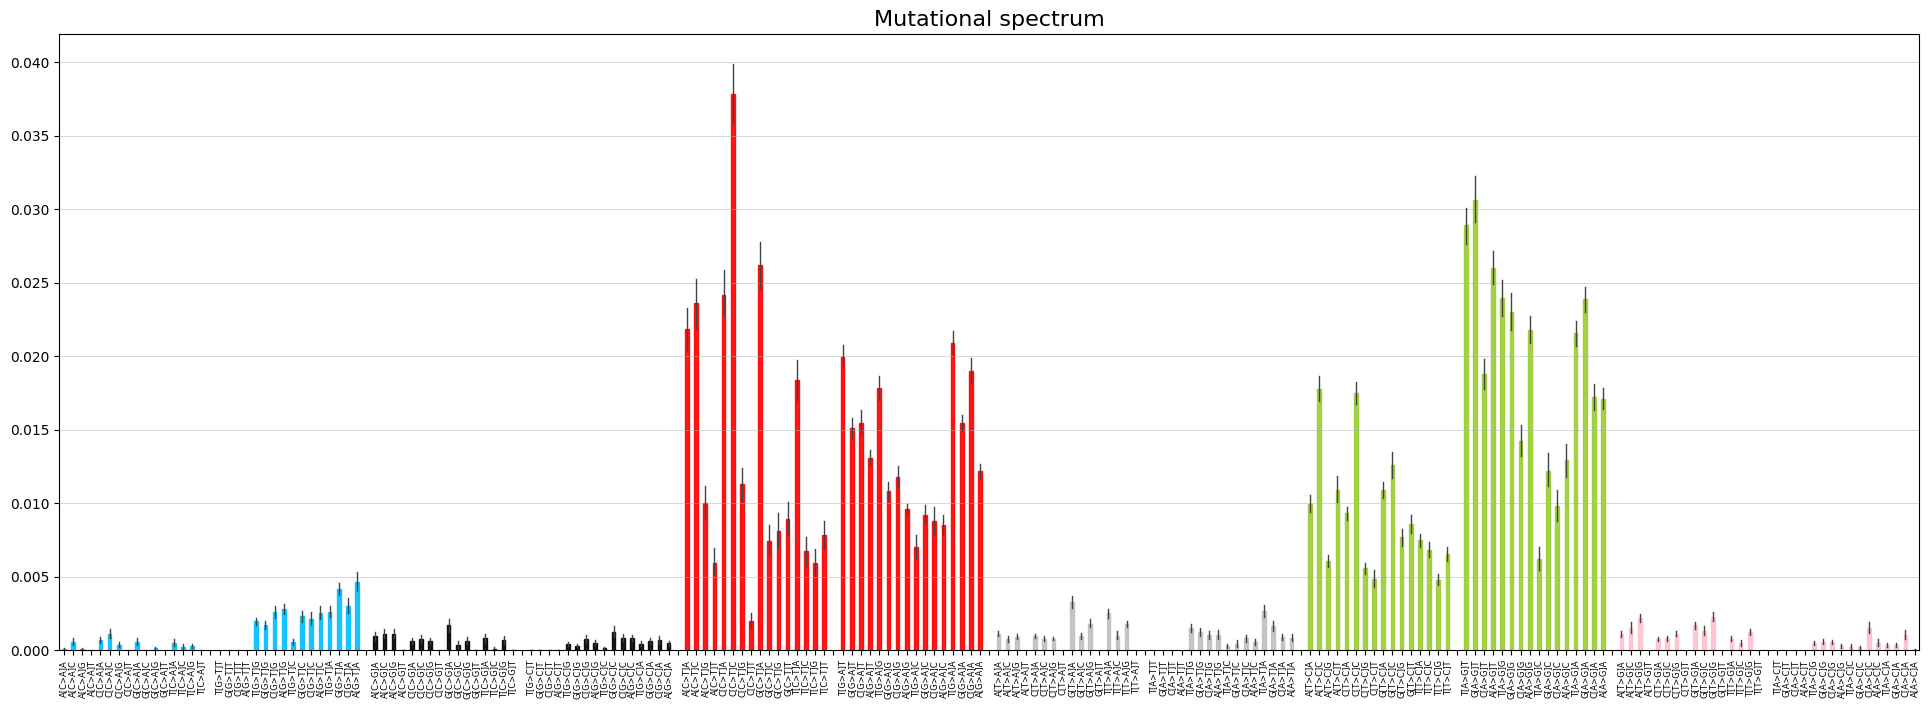

<AxesSubplot:title={'center':'Mutational spectrum'}>

In [36]:
plot_mutspec192(final_mutspec);

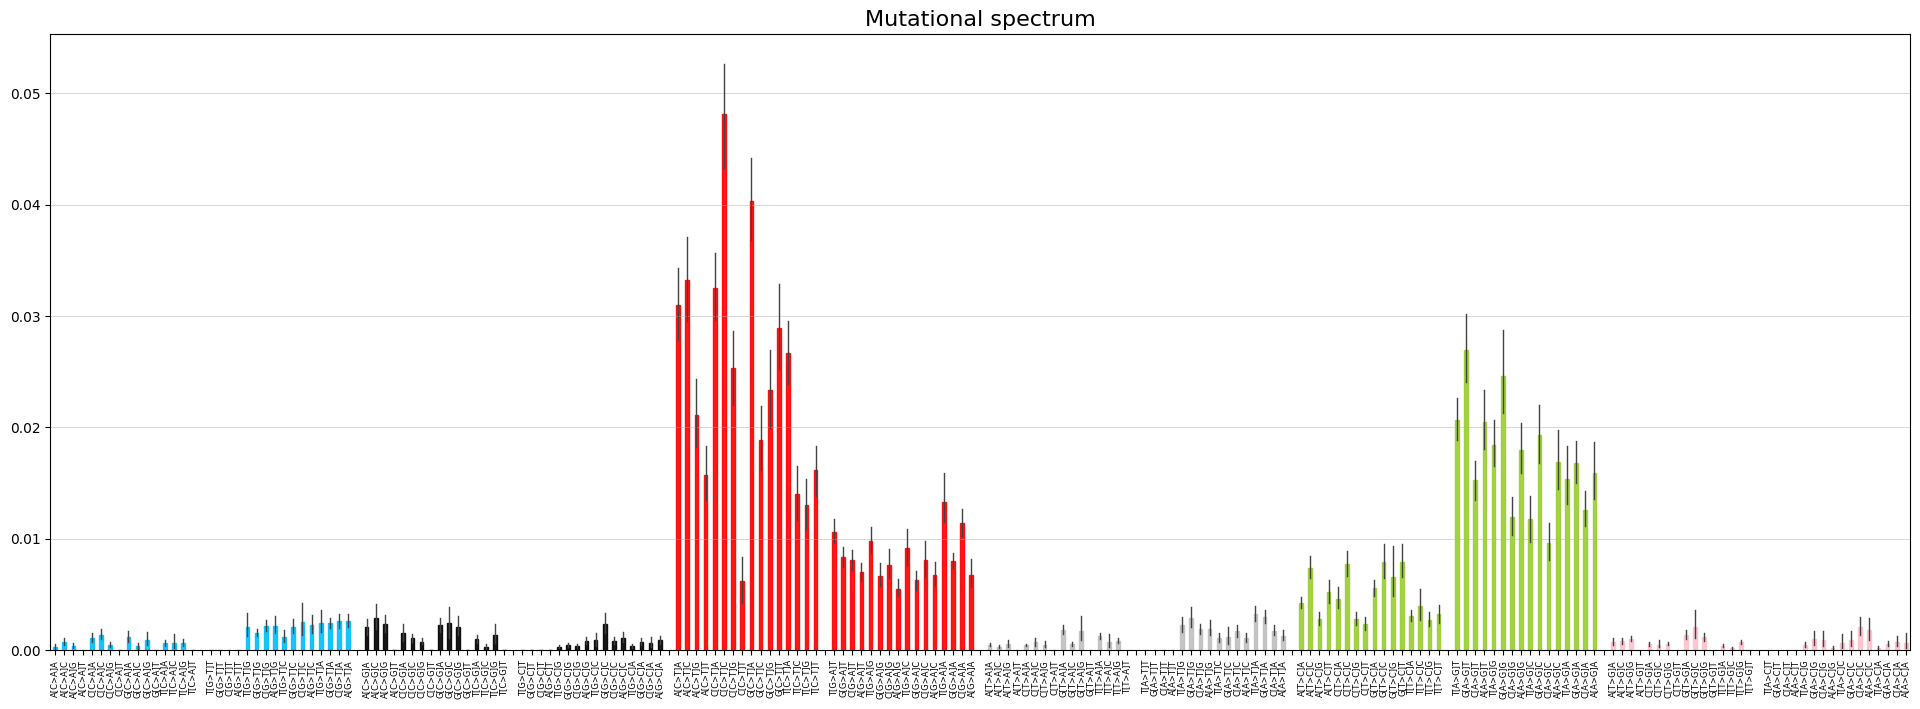

In [37]:
plot_mutspec192(spectra_old);

In [18]:
spectra_old = pd.read_csv('/home/kpotoh/192/data/MutSpecVertebratescytb.csv')
spectra_old.head()

,Species,Mut,Expected,Observed,RawMutSpec,RawMutSpecSum,MutSpec,MutBase,Context,Class
0,Abbottina_obtusirostris,T[T>G]T,0.0,0.0,0.0,1.088889,0.0,T>G,TTT,Actinopterygii
1,Abbottina_obtusirostris,G[T>G]T,0.0,0.0,0.0,1.088889,0.0,T>G,GTT,Actinopterygii
2,Abbottina_obtusirostris,C[T>G]T,0.0,0.0,0.0,1.088889,0.0,T>G,CTT,Actinopterygii
3,Abbottina_obtusirostris,A[T>G]T,0.0,0.0,0.0,1.088889,0.0,T>G,ATT,Actinopterygii
4,Abbottina_obtusirostris,T[T>C]T,8.0,0.0,0.0,1.088889,0.0,T>C,TTT,Actinopterygii


In [35]:
def calc_mutspec_class(df: pd.DataFrame):
    ms_cls = df.groupby(['Class','Mut'])['RawMutSpec'].sum().reset_index()
    ms_cls["RawMutSpecSum"] = ms_cls.Class.map(ms_cls.groupby("Class").RawMutSpec.sum().to_dict())
    ms_cls['MutSpec'] = ms_cls.RawMutSpec / ms_cls.RawMutSpecSum
    ms_cls = ms_cls.drop(['RawMutSpec', 'RawMutSpecSum'], axis=1)
    
    return ms_cls

In [43]:
mut_new = final_mutspec.loc[final_mutspec['Species'].isin(spectra_old['Species'].unique())]
mut_old = spectra_old.loc[spectra_old['Species'].isin(mut_new['Species'].unique())]

In [44]:
sps_to_cosin = mut_new.Species.unique()

In [45]:
mut_new['Class'] = 'Vertebrata'
mut_new = calc_mutspec_class(mut_new)
mut_old['Class'] = 'Vertebrata'
mut_old = calc_mutspec_class(mut_old)

In [39]:
1 - spatial.distance.cosine(mut_new['MutSpec'], mut_old['MutSpec'])

0.9248450130741519

In [40]:
mutspec_bogdan = pd.read_csv('/home/kpotoh/nemu-pipeline/data/chordata2/raw_spectum192.csv')

mutspec_bogdan = mutspec_bogdan.drop('Unnamed: 0', axis=1)

mutspec_bogdan = mutspec_bogdan[mutspec_bogdan.Gene == 'Cytb']

mutspec_bogdan['ExpNum'] = np.where(mutspec_bogdan['ExpNum'] < 0.99, 0, mutspec_bogdan['ExpNum'])
mutspec_bogdan['ObsNum'] = np.where(mutspec_bogdan['ObsNum'] < 0.99, 0, mutspec_bogdan['ObsNum'])

### Norm again
mutspec_bogdan["RawMutSpec"] = (mutspec_bogdan["ObsNum"] / mutspec_bogdan["ExpNum"]).fillna(0)
mutspec_bogdan["RawMutSpec"] = mutspec_bogdan["RawMutSpec"].replace(np.inf, 0)
rawsum_df = mutspec_bogdan.groupby("Species").RawMutSpec.sum().reset_index().rename(columns={"RawMutSpec": "RawMutSpecSum"})
mutspec_bogdan = pd.merge(mutspec_bogdan, rawsum_df, on="Species")
mutspec_bogdan["MutSpec"] = mutspec_bogdan["RawMutSpec"] / mutspec_bogdan["RawMutSpecSum"]


In [41]:
mutspec_bogdan['Mut'] = mutspec_bogdan.Mut.apply(getrevers) # change annotation to heavy STRAND
mutspec_bogdan["MutBase"] = mutspec_bogdan.Mut.str.slice(2, 5)
mutspec_bogdan["Context"] = mutspec_bogdan.Mut.str.get(0) + mutspec_bogdan.Mut.str.get(2) + mutspec_bogdan.Mut.str.get(-1)


In [46]:
mutspec_bogdan['Class'] = 'Vertebrata'

In [50]:
mut_bog = mutspec_bogdan.loc[mutspec_bogdan['Species'].isin(sps_to_cosin)]
mut_bog = calc_mutspec_class(mut_bog)

In [51]:
1 - spatial.distance.cosine(mut_new['MutSpec'], mut_bog['MutSpec'])

0.965254957470618

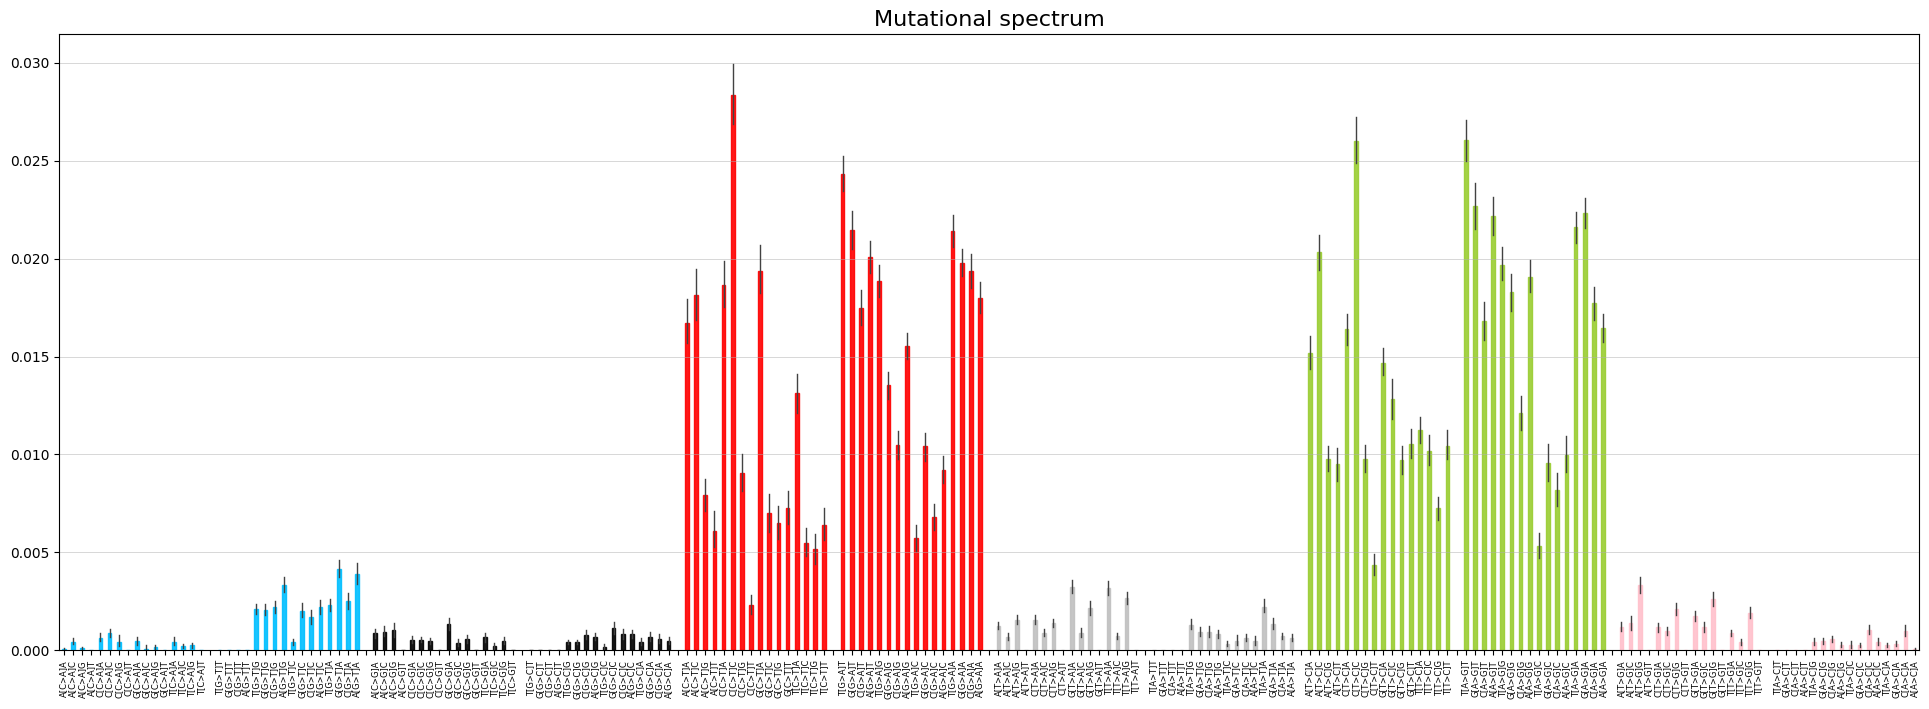

<AxesSubplot:title={'center':'Mutational spectrum'}>

In [33]:
plot_mutspec192(mutspec_bogdan)